## Building a Neural Network with TensorFlow

Using TensorFlow's API to build a neural network as a tensor graph.

In [14]:
import tensorflow as tf#Reset the tf graph
import numpy as np

In [15]:
#reset the TF graph

def reset_graph(seed=42): 
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [16]:
'''
Construction phase
----------------------------------------
Here we define the network in terms of: 
- input, hidden, output layers
- activation function: ReLu
- loss function: cross-entropy
- optimizer: mini-batch GD
- performacne evaluation: accuracy
'''

#specify the NN architecture

n_inputs = 28*28 # MNIST 
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [17]:
#We use placeholders for the input/output of the network. 
#For X, we know the number of features each instance will have (784) but we don't know
#how many instances each batch of the mini-batch GD will contain.

#Same for y, we know it's a single label per training instance but still rely on the
#number of instances in our mini-batch. Each Yi will contain the error of example Xi

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [4]:
#This function creates a layer in the NN. It takes an input layer X (units connected to this layer),
#number of neurons (units in the layer), name and an activation function.

#This has a TF implementation that does it- see TF's fully_connected function

def neuron_layer(X, n_neurons, name, activation=None): 
    #add namescope for better visualization in tensorboard
    with tf.name_scope(name):
        
        #get number of features from input
        n_inputs = int(X.get_shape()[1])
        
        #initialize W matrix with random weight.
        #W is the shape (n_features_input, n_neurons_nextlayer)
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev) 
        W = tf.Variable(init, name="weights")
        
        #bias edges in hidden layer
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        
        #hidden layer- net
        z = tf.matmul(X, W) + b
        
        #hidden layer- out
        if activation=="relu":
            return tf.nn.relu(z) 
        else:
            return z

In [11]:
#Create the DNN:
    #input layer: a training instance
    #hidden layer 1: 300
    #hidden layer 2: 100
    #output layer: 10

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu") 
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu") 
    logits = neuron_layer(hidden2, n_outputs, "outputs")

In [19]:
from tensorflow.contrib.layers import fully_connected

#The TF implementation for our 'neuron_layer' function

with tf.name_scope("dnn"):
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1", reuse=True) 
    hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2", reuse=True) 
    logits = fully_connected(hidden2, n_outputs, scope="outputs",
                                 activation_fn=None, reuse=True)


In [20]:
#define cross-entropy loss function for the output layer.

with tf.name_scope("loss"):
    
    #computes the cross-entropy loss of each output node
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    #computes the total error as a mean over the cross-entropies
    loss = tf.reduce_mean(xentropy, name="loss")

In [21]:
#define a gradient-descent optimizer to minimize the loss function

learning_rate = 0.01

with tf.name_scope("train"):
    #this will minimize the loss, a TF node that contains the rest 
    #of our nodes: X,W and y
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
    training_op = optimizer.minimize(loss)


In [22]:
#Model Evaluation

with tf.name_scope("eval"):
    
    #foreach prediction i (logits) determine wether the highest logit 
    #(amonge the topk predictions where k=1) corresponds to the target class
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [24]:
#initializer and saver

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
'''
Execution Phase
-------------------
- Load, scale and split the MNIST data: done by TF read_data_sets method
- Define execution parameters: ephocs and batch size
- Run training, evaluate every epoch
- Save network to disk
'''
from tensorflow.examples.tutorials.mnist import input_data

#load data using TF's API. Loads, scales and shuffles the data
mnist = input_data.read_data_sets("/tmp/data/")

#define mini-batch GD parameters
n_epochs = 30
batch_size = 50


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [34]:
with tf.Session() as sess: 
    #initialize all nodes in the graph
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            
            #get batch i - examples and targets
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            #feed batch to network - all examples in a batch will run in parallel.
            #populate the place holders in the graph
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        #train/test sets accuracy measurments
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels}) 
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.94 Test accuracy: 0.9013
1 Train accuracy: 0.9 Test accuracy: 0.9224
2 Train accuracy: 1.0 Test accuracy: 0.9337
3 Train accuracy: 0.96 Test accuracy: 0.9376
4 Train accuracy: 0.9 Test accuracy: 0.9428
5 Train accuracy: 0.98 Test accuracy: 0.9468
6 Train accuracy: 0.94 Test accuracy: 0.9522
7 Train accuracy: 0.96 Test accuracy: 0.9543
8 Train accuracy: 0.92 Test accuracy: 0.9572
9 Train accuracy: 0.98 Test accuracy: 0.9595
10 Train accuracy: 0.98 Test accuracy: 0.9612
11 Train accuracy: 0.92 Test accuracy: 0.9643
12 Train accuracy: 0.96 Test accuracy: 0.9646
13 Train accuracy: 1.0 Test accuracy: 0.9647
14 Train accuracy: 1.0 Test accuracy: 0.9657
15 Train accuracy: 0.96 Test accuracy: 0.9671
16 Train accuracy: 0.98 Test accuracy: 0.9683
17 Train accuracy: 0.98 Test accuracy: 0.9689
18 Train accuracy: 0.98 Test accuracy: 0.9691
19 Train accuracy: 0.98 Test accuracy: 0.9708
20 Train accuracy: 1.0 Test accuracy: 0.9701
21 Train accuracy: 0.98 Test accuracy: 0.9714
22 T

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


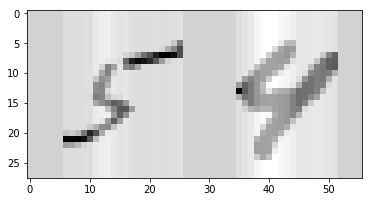

In [52]:
#Use the network on a "new" examples

from sklearn.datasets import fetch_mldata
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#Get 2 digits from the dataset
mnist = fetch_mldata('MNIST original')
target = mnist.target.reshape(mnist.target.shape[0], 1)
data = mnist.data

digit_5 = scaler.fit_transform(data[35000].reshape(28, 28))
digit_4 = scaler.fit_transform(data[29999].reshape(28, 28))
digits = np.c_[digit_5, digit_4]

plt.imshow(digits, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.show()

In [57]:


with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    digit4_new_scaled = digit_4.reshape(1,784)
    Z = logits.eval(feed_dict={X: digit4_new_scaled})
    y_pred = np.argmax(Z, axis=1)
    
    print ('prediction: ', y_pred)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
prediction:  [4]
